## IMPORTING LIBRARIES

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

## LOADING AND PREPROCESSING DATA

In [2]:
# Load dataset
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"
df = pd.read_csv(url, delimiter='\t', header=None, names=['label', 'text'])

# Preprocess dataset
def preprocess_text(text):
    return text.lower().split()

df['text'] = df['text'].apply(preprocess_text)
df = df[['text', 'label']]

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Split dataset
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Vocabulary and indexing
vocab = set([word for phrase in df['text'] for word in phrase])
word_to_idx = {word: idx for idx, word in enumerate(vocab, 1)}

def encode_phrase(phrase):
    return [word_to_idx[word] for word in phrase]

train_data['text'] = train_data['text'].apply(encode_phrase)
test_data['text'] = test_data['text'].apply(encode_phrase)

# Padding sequences
max_length = max(df['text'].apply(len))

def pad_sequence(seq, max_length):
    return seq + [0] * (max_length - len(seq))

train_data['text'] = train_data['text'].apply(lambda x: pad_sequence(x, max_length))
test_data['text'] = test_data['text'].apply(lambda x: pad_sequence(x, max_length))

## CREATING DATASET AND DATA LOADER

In [3]:
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.texts = data['text'].values
        self.labels = data['label'].values
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
len(test_loader)

35

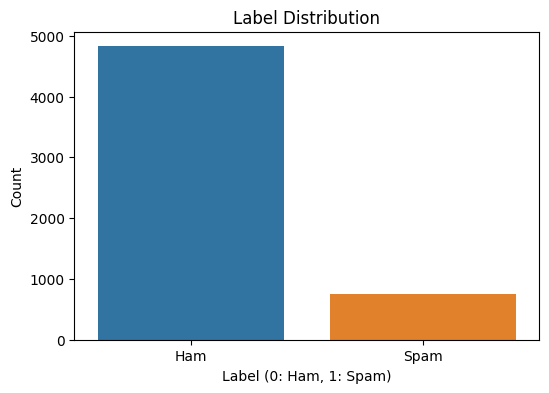

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


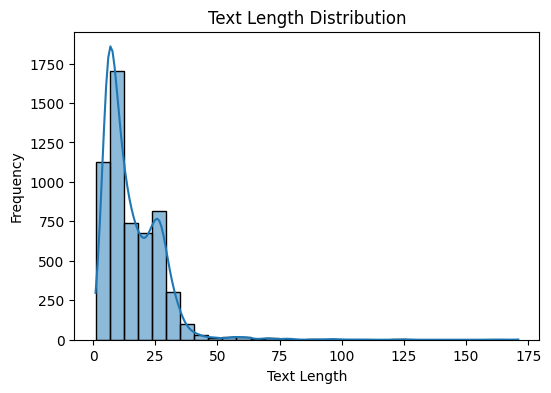

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


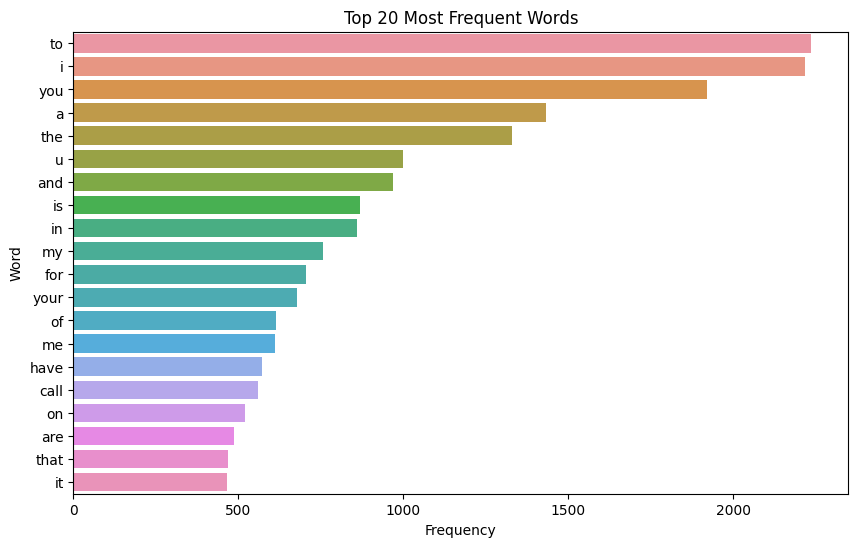

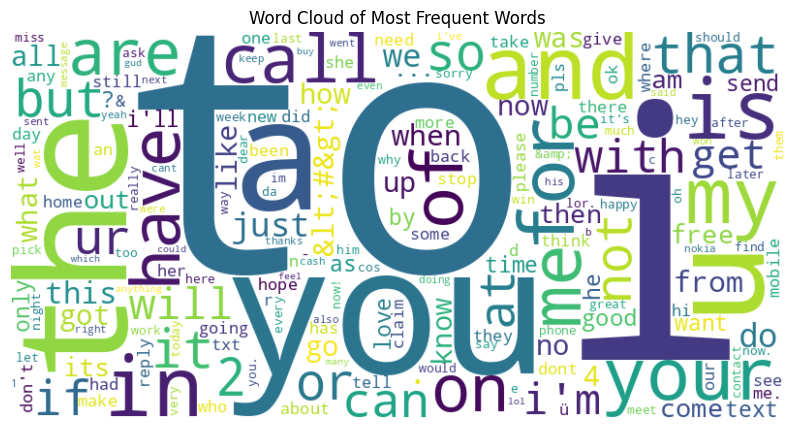

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# 1. Plot label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xlabel('Label (0: Ham, 1: Spam)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

# 2. Plot text length distribution
text_lengths = df['text'].apply(len)

plt.figure(figsize=(6, 4))
sns.histplot(text_lengths, kde=True, bins=30)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 3. Plot most frequent words
all_words = [word for phrase in df['text'] for word in phrase]
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Plot the top 20 most common words
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# 4. Word cloud visualization of most frequent words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()


In [6]:
# Iterate through the train_loader
for i, (texts, labels) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"  Input shape: {texts.shape}")
    print(f"  Labels shape: {labels.shape}")
    if i == 2:  # Limit the number of batches printed for brevity
        break

# Similarly for validation and test loaders
for i, (texts, labels) in enumerate(test_loader):
    print(f"Validation Batch {i+1}:")
    print(f"  Input shape: {texts.shape}")
    print(f"  Labels shape: {labels.shape}")
    if i == 2:  # Limit for brevity
        break


Batch 1:
  Input shape: torch.Size([32, 171])
  Labels shape: torch.Size([32])
Batch 2:
  Input shape: torch.Size([32, 171])
  Labels shape: torch.Size([32])
Batch 3:
  Input shape: torch.Size([32, 171])
  Labels shape: torch.Size([32])
Validation Batch 1:
  Input shape: torch.Size([32, 171])
  Labels shape: torch.Size([32])
Validation Batch 2:
  Input shape: torch.Size([32, 171])
  Labels shape: torch.Size([32])
Validation Batch 3:
  Input shape: torch.Size([32, 171])
  Labels shape: torch.Size([32])


## Model Architecture

In [7]:
class SentimentAnalysis(nn.Module):
    def __init__(self, vocab_size,embed_size, hidden_size, output_size):
        super(SentimentAnalysis, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.embedding(x)
        # h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        # out, _ = self.rnn(x, h0)
        out, _ = self.rnn(x)
        out = self.fc(out[:,-1,:])
        return out


vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
output_size = 2 # binary classification
model = SentimentAnalysis(vocab_size, embed_size, hidden_size, output_size)

## TRAINING THE MODEL

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        output = model(texts)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')
        

Epoch [1/50], Loss: 0.4165
Epoch [2/50], Loss: 0.4265
Epoch [3/50], Loss: 0.4179
Epoch [4/50], Loss: 0.4209
Epoch [5/50], Loss: 0.4101
Epoch [6/50], Loss: 0.4178
Epoch [7/50], Loss: 0.4245
Epoch [8/50], Loss: 0.4134
Epoch [9/50], Loss: 0.4197
Epoch [10/50], Loss: 0.4172
Epoch [11/50], Loss: 0.4286
Epoch [12/50], Loss: 0.4107
Epoch [13/50], Loss: 0.4273
Epoch [14/50], Loss: 0.4236
Epoch [15/50], Loss: 0.4393
Epoch [16/50], Loss: 0.4183
Epoch [17/50], Loss: 0.4108
Epoch [18/50], Loss: 0.4193
Epoch [19/50], Loss: 0.4124
Epoch [20/50], Loss: 0.4121
Epoch [21/50], Loss: 0.4193
Epoch [22/50], Loss: 0.4389
Epoch [23/50], Loss: 0.4216
Epoch [24/50], Loss: 0.4257
Epoch [25/50], Loss: 0.4180
Epoch [26/50], Loss: 0.4499
Epoch [27/50], Loss: 0.4170
Epoch [28/50], Loss: 0.4023
Epoch [29/50], Loss: 0.4210
Epoch [30/50], Loss: 0.4145
Epoch [31/50], Loss: 0.4239
Epoch [32/50], Loss: 0.4156
Epoch [33/50], Loss: 0.4111
Epoch [34/50], Loss: 0.4316
Epoch [35/50], Loss: 0.4353
Epoch [36/50], Loss: 0.4183
E

## EVALUATE THE MODEL


In [15]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct/ total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 86.64%
